In [2]:
import pandas as pd
import numpy as np
import math
from darts.models import NBEATSModel, RNNModel, TCNModel, TransformerModel
from darts.timeseries import TimeSeries as ts
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse,mape,mse
import pickle

The StatsForecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


In [3]:
df = pd.read_csv('San_Juan_Dengue_Data_Cleaned.csv')
df

,week_start_date,total_cases
0,1990-04-30,4
1,1990-05-07,5
2,1990-05-14,4
3,1990-05-21,3
4,1990-05-28,6
...,...,...
983,2009-03-26,24
984,2009-04-02,9
985,2009-04-09,21
986,2009-04-16,10


In [4]:
import pandas as pd

# Ensure the 'week_start_date' column is in datetime format
df['week_start_date'] = pd.to_datetime(df['week_start_date'])

# Set the 'week_start_date' as the index and enforce a 7-day frequency
df.set_index('week_start_date', inplace=True)

# Use asfreq with forward fill to handle any potential missing data points
df = df.asfreq('7D', method='ffill')

# Reset the index to pass it to your ts object
df.reset_index(inplace=True)

# Now pass the dataframe to your ts object
ts_dengue = ts.from_dataframe(df, time_col='week_start_date', value_cols='total_cases')


In [5]:
ts_dengue

<TimeSeries (DataArray) (week_start_date: 991, component: 1, sample: 1)>
array([[[  4.]],

       [[  5.]],

       [[  4.]],

       [[  3.]],

       [[  6.]],

       [[  2.]],

       [[  4.]],

       [[  5.]],

       [[ 10.]],

       [[  6.]],

...

       [[ 41.]],

       [[ 35.]],

       [[ 28.]],

       [[ 28.]],

       [[ 22.]],

       [[ 26.]],

       [[ 24.]],

       [[  9.]],

       [[ 21.]],

       [[ 10.]]])
Coordinates:
  * week_start_date  (week_start_date) datetime64[ns] 1990-04-30 ... 2009-04-20
  * component        (component) object 'total_cases'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [6]:
nan_values = ts_dengue.pd_dataframe().isna().sum()

In [7]:
nan_values

component
total_cases    0
dtype: int64

<Axes: xlabel='week_start_date'>

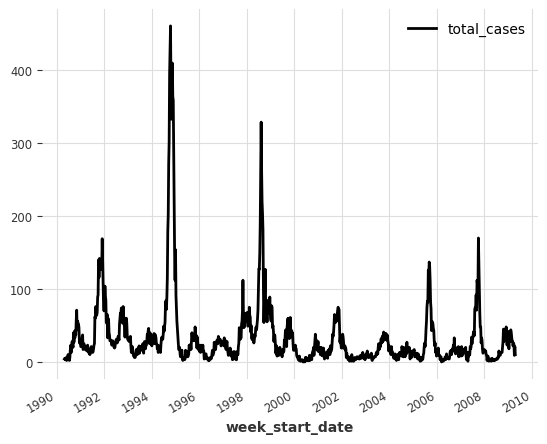

In [8]:
ts_dengue.plot()

In [14]:
ts_dengue

<TimeSeries (DataArray) (week_start_date: 991, component: 1, sample: 1)>
array([[[  4.]],

       [[  5.]],

       [[  4.]],

       [[  3.]],

       [[  6.]],

       [[  2.]],

       [[  4.]],

       [[  5.]],

       [[ 10.]],

       [[  6.]],

...

       [[ 41.]],

       [[ 35.]],

       [[ 28.]],

       [[ 28.]],

       [[ 22.]],

       [[ 26.]],

       [[ 24.]],

       [[  9.]],

       [[ 21.]],

       [[ 10.]]])
Coordinates:
  * week_start_date  (week_start_date) datetime64[ns] 1990-04-30 ... 2009-04-20
  * component        (component) object 'total_cases'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [15]:
scaler = Scaler()
ts_dengue_scaled = scaler.fit_transform(ts_dengue)

In [135]:
len(ts_dengue_scaled)

991

In [16]:
ts_dengue_train = ts_dengue_scaled[:981]

In [17]:
len(ts_dengue_train)

981

In [138]:
model_name = "Nbeats100Epochs"
model = NBEATSModel(
    input_chunk_length=10,
    output_chunk_length=5,
    n_epochs=100,
    activation='LeakyReLU',
    model_name = model_name,
    save_checkpoints=True,
    force_reset=True,
)

In [139]:
model.fit(ts_dengue_train, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.3 K     Non-trainable params
6.1 M     Total params
24.342    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=LeakyReLU, input_chunk_length=10, output_chunk_length=5, n_epochs=100, model_name=Nbeats100Epochs, save_checkpoints=True, force_reset=True)

In [140]:
with open('TrainedModel.pkl', 'wb') as file:
    pickle.dump(model, file)

In [10]:
with open('Finalscaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

NameError: name 'scaler' is not defined

In [142]:
with open('TrainedModel.pkl', 'rb') as file:
   loaded = pickle.load(file)

In [143]:
loaded

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=LeakyReLU, input_chunk_length=10, output_chunk_length=5, n_epochs=100, model_name=Nbeats100Epochs, save_checkpoints=True, force_reset=True)

In [145]:
pred = model.predict(n=10, series=ts_dengue_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [13]:
import pickle
with open('Finalscaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)

EOFError: Ran out of input

In [147]:
prediction = loaded_scaler.inverse_transform(pred)
predicted_value = []
for i in prediction:
    predicted_value.append(i.values()[0][0])

In [148]:
predicted_value

[41.75340956827888,
 46.09966226024707,
 53.949113835603036,
 55.66510969705376,
 54.99243526406996,
 57.58422487947975,
 62.49322995674219,
 75.4065852330817,
 77.78788042410207,
 75.7085637280247]

In [150]:
actual_value = []
#actual = ts_dengue_scaled[-10:]
actual = loaded_scaler.inverse_transform(ts_dengue_scaled[-10:])
for i in actual:
    actual_value.append(i.values()[0][0])

In [151]:
actual_value

[41.0, 35.0, 28.0, 28.0, 22.0, 26.0, 24.0, 9.0, 21.0, 10.0]

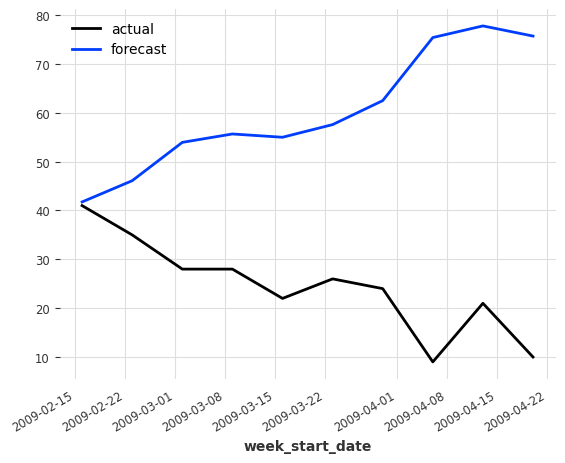

In [153]:
import matplotlib.pyplot as plt
actual.plot(label='actual')
prediction.plot(label='forecast')
plt.legend()

In [154]:
mae_value = mae(actual, prediction)

In [155]:
mae_value

35.744021484668316

Retrain Using Best Hyperparameter

In [1]:
import json
with open("best_params.json", "r") as f:
    loaded_params = json.load(f)

In [19]:
# Train the model using the loaded parameters
model = NBEATSModel(
    input_chunk_length=loaded_params['input_chunk_length'],
    output_chunk_length=loaded_params['output_chunk_length'],
    n_epochs=loaded_params['n_epochs'],
    activation=loaded_params['activation'],
    #model_name="model_name",  # Add your model name here
    #save_checkpoints=True,
    #force_reset=True,
    num_stacks=loaded_params['num_stacks'],
    num_blocks=loaded_params['num_blocks'],
    num_layers=loaded_params['num_layers'],
    layer_widths=loaded_params['layer_widths'],
    expansion_coefficient_dim=loaded_params['expansion_coefficient_dim'],
    trend_polynomial_degree=loaded_params['trend_polynomial_degree'],
    dropout=loaded_params['dropout'],
    batch_size=loaded_params['batch_size']
)

In [20]:
model.fit(ts_dengue_train, verbose=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 56.1 M | train
-------------------------------------------------------------
56.1 M    Trainable params
3.4 K     Non-trainable params
56.1 M    Total params
224.327   Total estimated model params size (MB)
694       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=43` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=43, num_blocks=1, num_layers=4, layer_widths=653, expansion_coefficient_dim=5, trend_polynomial_degree=3, dropout=0.10870316683314804, activation=LeakyReLU, input_chunk_length=24, output_chunk_length=5, n_epochs=43, batch_size=63)

In [21]:
pred = model.predict(n=10, series=ts_dengue_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
prediction = scaler.inverse_transform(pred)
predicted_value = []
for i in prediction:
    predicted_value.append(i.values()[0][0])

In [24]:
actual_value = []
#actual = ts_dengue_scaled[-10:]
actual = scaler.inverse_transform(ts_dengue_scaled[-10:])
for i in actual:
    actual_value.append(i.values()[0][0])

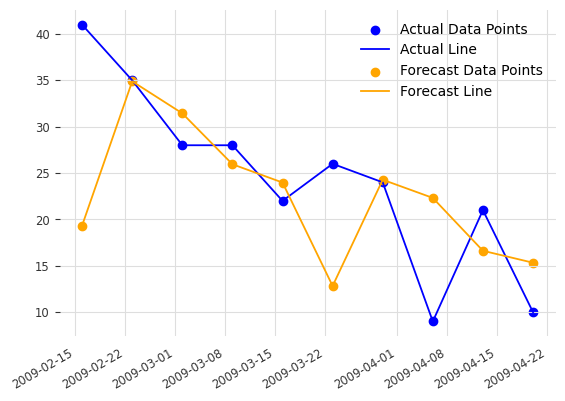

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot actual values with data points and a line
plt.scatter(actual.time_index, actual.values(), label='Actual Data Points', color='blue')
plt.plot(actual.time_index, actual.values(), label='Actual Line', color='blue')

# Plot prediction values with data points and a line
plt.scatter(prediction.time_index, prediction.values(), label='Forecast Data Points', color='orange')
plt.plot(prediction.time_index, prediction.values(), label='Forecast Line', color='orange')

# Format the x-axis to avoid overlapping date labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotate the x-axis date labels for better readability
plt.gcf().autofmt_xdate()

# Add legend and show plot
plt.legend()
plt.show()



In [35]:
actual_value, predicted_value

([41.0, 35.0, 28.0, 28.0, 22.0, 26.0, 24.0, 9.0, 21.0, 10.0],
 [19.3425197229279,
  34.89462134229216,
  31.440582278128684,
  25.951928399579543,
  23.978391481079615,
  12.824746867203256,
  24.281890078515872,
  22.319810033085055,
  16.620567957043708,
  15.332298951311813])

In [36]:
mae_value = mae(actual, prediction)

In [37]:
mae_value

6.571858853307447

In [38]:
with open('TunedModel.pkl', 'wb') as file:
   loaded = pickle.dump(model, file)

with open('Finalscaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)